In [756]:
from urllib.request import urlopen as ureq
from bs4 import BeautifulSoup as soup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

palette = "viridis"

wiki_crew_url = "https://en.wikipedia.org/wiki/Crew_of_the_Titanic"
wiki_pass_url = "https://en.wikipedia.org/wiki/Passengers_of_the_Titanic"

# Wikipedia Tables Import (pandas)

In [738]:
pd_crew_tables = pd.read_html(wiki_crew_url)
pd_pass_tables = pd.read_html(wiki_pass_url)
print(pd_crew_tables[0].head())
print(pd_pass_tables[1].head())

                                              Name  Age  \
0                Smith, Commander Edward John, RNR   62   
1              Wilde, Lieutenant Henry Tingle, RNR   39   
2        Murdoch, Lieutenant William McMaster, RNR   39   
3  Lightoller, Sub-Lieutenant Charles Herbert, RNR   38   
4                         Pitman, Mr. Herbert John   34   

                                         Hometown      Boarded  \
0  Hanley, Stoke-on-Trent, Staffordshire, England  Southampton   
1                     Walton, Lancashire, England  Southampton   
2        Dalbeattie, Kirkcudbrightshire, Scotland      Belfast   
3                      Netley, Hampshire, England      Belfast   
4                  Castle Cary, Somerset, England      Belfast   

         Position Lifeboat  Body  
0         Captain      NaN   NaN  
1   Chief Officer      NaN   NaN  
2   First Officer      NaN   NaN  
3  Second Officer        B   NaN  
4   Third Officer        5   NaN  
                                      

# Wikipedia Tables Import (soup)

We have to gather html sources because "survived" indicator is a row color in wikipedia articles.

In [739]:
client = ureq(wiki_crew_url)
crew_html = soup(client.read(), "html.parser")
client.close()
client = ureq(wiki_pass_url)
pass_html = soup(client.read(), "html.parser")
client.close()

html_crew_tables = crew_html.findAll('table', attrs={'class':'wikitable'})
html_pass_tables = pass_html.findAll('table', attrs={'class':'wikitable'})

In [740]:
crew_groups = {
    "Officers": [html_crew_tables[0], pd_crew_tables[0]],
    "Deck": [html_crew_tables[1], pd_crew_tables[1]],
    "Engineering": [html_crew_tables[2], pd_crew_tables[2]],
    "Victualling": [html_crew_tables[3], pd_crew_tables[3]],
    "Restaurant": [html_crew_tables[4], pd_crew_tables[4]],
    "Postal Clerks": [html_crew_tables[5], pd_crew_tables[5]],
    "Guarantee": [html_crew_tables[6], pd_crew_tables[6]],
    "Orchestra": [html_crew_tables[7], pd_crew_tables[7]]
}

pass_groups = {
    "First Class": [html_pass_tables[0], pd_pass_tables[1]],
    "Second Class": [html_pass_tables[1], pd_pass_tables[2]],
    "Third Class": [html_pass_tables[2], pd_pass_tables[3]]
}

In [741]:
df_crew_survived = pd.DataFrame(columns=["Name", "Survived"])
df_pass_survived = pd.DataFrame(columns=["Name", "Survived"])

for group, tables in crew_groups.items():
    table_body = tables[0].find('tbody')
    rows = table_body.find_all('tr')[1:] # drop table header
    for row in rows:
        df_crew_survived.loc[len(df_crew_survived)] = [row.find_all('td')[0].text, row.has_attr("style")]

for group, tables in pass_groups.items():
    table_body = tables[0].find('tbody')
    rows = table_body.find_all('tr')[1:] # drop table header
    for row in rows:
        df_pass_survived.loc[len(df_pass_survived)] = [row.find_all('td')[0].text, row.has_attr("style")]

print(df_crew_survived.head())
print(df_pass_survived.head())

                                              Name Survived
0                Smith, Commander Edward John, RNR    False
1              Wilde, Lieutenant Henry Tingle, RNR    False
2        Murdoch, Lieutenant William McMaster, RNR    False
3  Lightoller, Sub-Lieutenant Charles Herbert, RNR     True
4                         Pitman, Mr. Herbert John     True
                                             Name Survived
0                    Allen, Miss Elizabeth Walton     True
1                   Allison, Mr. Hudson Creighton    False
2             and chauffeur, Mr. George Swane[71]    False
3  and cook, Miss Amelia Mary "Mildred" Brown[71]     True
4        Allison, Mrs. Bessie Waldo (née Daniels)    False


# Joining Data, Extraction of Additional Features

In [742]:
male_salutations = ["Mr.", "Master", "Father", "Dr.", "Mr ", "Mr,", "Mr,", "Colonel", "Major", "Captain", "Sir ", "Don ", "Reverend"]
female_salutations = ["Ms.", "Mrs", "Miss", "Lady", "Countess", "Doña"]

def predict_sex(group, name):
    if any(ms in name for ms in male_salutations):
        return "M"
    elif any(fs in name for fs in female_salutations):
        return "F"
    elif group == "Officers" or group == "Orchestra":
        return "M"
    else:
        return "U"

def complete_df_item(item, group):
    item["Sex"] = predict_sex(group, item["Name"])
    item["Group"] = group
    return item

In [743]:
df_crew = pd.DataFrame(columns=["Name", "Age", "Hometown", "Boarded", "Position", "Lifeboat", "Body", "Sex", "Group"])
df_pass = pd.DataFrame(columns=["Name", "Age", "Hometown", "Boarded", "Destination", "Lifeboat", "Body", "Sex", "Group"])

for group, tables in crew_groups.items():
    df_crew = df_crew.append(tables[1].merge(right = df_crew_survived, on = "Name").apply(lambda row : complete_df_item(row, group),axis=1))
    
for group, tables in pass_groups.items():
    tables[1] = tables[1].rename(columns={"age": "Age"}) # preserve different age column titles
    df_pass = df_pass.append(tables[1].merge(right = df_pass_survived, on = "Name").apply(lambda row : complete_df_item(row, group),axis=1))

# drop unnecessary/redundant columns
df_crew = df_crew.drop(["Class"], axis=1)
df_pass = df_pass.loc[:, ~df_pass.columns.str.contains('^Unnamed')]

print(df_crew.head())
print(df_pass.head())
print(df_crew[df_crew['Sex'] == 'U'])
print(df_pass[df_pass['Sex'] == 'U'])

                                              Name Age  \
0                Smith, Commander Edward John, RNR  62   
1              Wilde, Lieutenant Henry Tingle, RNR  39   
2        Murdoch, Lieutenant William McMaster, RNR  39   
3  Lightoller, Sub-Lieutenant Charles Herbert, RNR  38   
4                         Pitman, Mr. Herbert John  34   

                                         Hometown      Boarded  \
0  Hanley, Stoke-on-Trent, Staffordshire, England  Southampton   
1                     Walton, Lancashire, England  Southampton   
2        Dalbeattie, Kirkcudbrightshire, Scotland      Belfast   
3                      Netley, Hampshire, England      Belfast   
4                  Castle Cary, Somerset, England      Belfast   

         Position Lifeboat Body Sex     Group Survived  
0         Captain      NaN  NaN   M  Officers    False  
1   Chief Officer      NaN  NaN   M  Officers    False  
2   First Officer      NaN  NaN   M  Officers    False  
3  Second Officer        B

# Plots
Some code pieces may be duplicated. They key priority was making things easily readable in step-by-step mode.

## Survival Statistics (Crew & Passangers)

In [744]:
df_crew_summary = df_crew[['Survived']]
df_crew_summary = df_crew_summary.assign(Type='Crew')
df_pass_summary = df_pass[['Survived']]
df_pass_summary = df_pass_summary.assign(Type='Passengers')
df_all = pd.concat([df_crew_summary, df_pass_summary], axis=0)
print(df_all.head())

  Survived  Type
0    False  Crew
1    False  Crew
2    False  Crew
3     True  Crew
4     True  Crew


In [745]:
def ss_apply_labels(patches, stat):
    for i, rect in enumerate(patches):
        height = rect.get_height()
        ss_ax.text(
            rect.get_x() + rect.get_width() / 2, 20, stat[i], ha="center", va="bottom", color="white"
        )

['705 (77%)', '802 (62%)']
['214 (23%)', '492 (38%)']


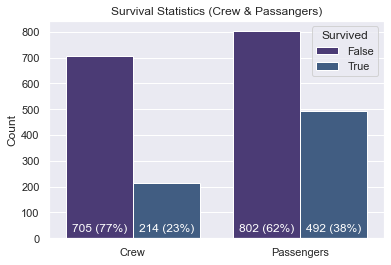

In [788]:
ss_ax = sns.countplot(data=df_all, x='Type', hue='Survived', palette=sns.color_palette(palette))
ss_ax.set_xlabel("")
ss_ax.set_ylabel("Count")
ss_ax.set(title='Survival Statistics (Crew & Passangers)')

crew_pct = len(df_crew_summary) / 100
crew_abs_perished = len(df_crew_summary[df_crew_summary['Survived'] == False])
crew_abs_survived = len(df_crew_summary[df_crew_summary['Survived'] == True])
pass_pct = len(df_pass_summary) / 100
pass_abs_perished = len(df_pass_summary[df_pass_summary['Survived'] == False])
pass_abs_survived = len(df_pass_summary[df_pass_summary['Survived'] == True])
stat_perished = [str(crew_abs_perished) + " (" + str(round(crew_abs_perished / crew_pct)) + "%)",
                 str(pass_abs_perished) + " (" + str(round(pass_abs_perished / pass_pct)) + "%)"]
stat_survived = [str(crew_abs_survived) + " (" + str(round(crew_abs_survived / crew_pct)) + "%)",
                str(pass_abs_survived) + " (" + str(round(pass_abs_survived / pass_pct)) + "%)"]

print(stat_perished)
print(stat_survived)

patch_perished = ss_ax.patches[:len(ss_ax.patches)//2]
patch_survived = ss_ax.patches[len(ss_ax.patches)//2:]

# apply labels with slight alignments
ss_apply_labels(patch_perished, stat_perished)
ss_apply_labels(patch_survived, stat_survived)

ss_ax.get_figure().savefig('ss.png', dpi=500, bbox_inches='tight')

## Crew Survival Statistics (Per Team)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


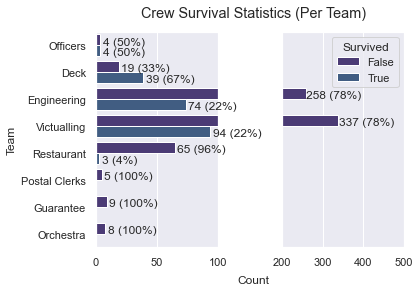

In [789]:
break_window = [100, 200]

def css_apply_labels(patches, stat, shift):
    for i, rect in enumerate(patches):
        height = rect.get_height()
        if rect.get_width() < break_window[0]:
            css_ax1.text(
                rect.get_width() + 2, i + shift, stat[i], ha="left", va="bottom"
            )
        else:
            css_ax2.text(
                rect.get_width() + 2, i + shift, stat[i], ha="left", va="bottom"
            )    

stat_perished = []
stat_survived = []
        
for g in crew_groups.keys():
    pct = len(df_crew[df_crew['Group'] == g]) / 100
    abs_perished = len(df_crew[(df_crew['Survived'] == False) & (df_crew['Group'] == g)])
    abs_survived = len(df_crew[(df_crew['Survived'] == True) & (df_crew['Group'] == g)])
    
    stat_perished.append(str(abs_perished) + " (" + str(round(abs_perished / pct)) + "%)")
    stat_survived.append(str(abs_survived) + " (" + str(round(abs_survived / pct)) + "%)")

fig, (css_ax1, css_ax2) = plt.subplots(1, 2, sharey=True)    
fig.subplots_adjust(wspace=0.0)

css_ax1 = sns.countplot(data=df_crew, y='Group', hue='Survived', ax=css_ax1, palette=sns.color_palette(palette))
css_ax2 = sns.countplot(data=df_crew, y='Group', hue='Survived', ax=css_ax2, palette=sns.color_palette(palette))
css_ax1.set_xlim(0, break_window[0]) # most of the data
css_ax2.set_xlim(break_window[1], 500) # outliers only
css_ax2.get_yaxis().set_visible(False)
css_ax1.get_legend().remove()

css_ax1.set_xlabel("")
css_ax1.set_ylabel("Team")
css_ax2.set_ylabel("")
css_ax2.set_xlabel("")
fig.text(0.6,0.00, "Count", ha="center", va="center")
fig.suptitle('Crew Survival Statistics (Per Team)', x=0.6, y=0.95, ha="center")

patch_perished = css_ax1.patches[:len(ax1.patches)//2]
patch_survived = css_ax1.patches[len(ax1.patches)//2:]

# apply labels with slight alignments
css_apply_labels(patch_perished, stat_perished, 0.05)
css_apply_labels(patch_survived, stat_survived, 0.45)

plt.tight_layout()
fig.savefig('css.png', dpi=500, bbox_inches='tight')
plt.show()

## Crew Gender Statistics (Per Team)

For those who are wondering why only two genders are used: there are only two genders we can extract from the dataset :(

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[8, 58, 332, 410, 66, 5, 9, 8]
[0, 0, 0, 21, 2, 0, 0, 0]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


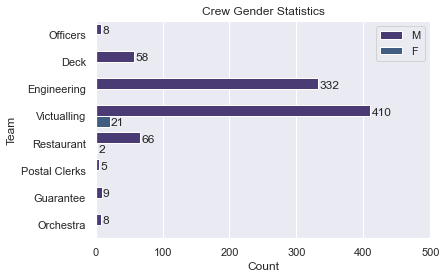

In [797]:
def cgs_apply_labels(patches, stat, shift):
    for i, rect in enumerate(patches):
        height = rect.get_height()
        cgs_ax.text(
            rect.get_width() + 2, i + shift, stat[i], ha="left", va="bottom"
        ) 
            

df_crew_sex_summary = df_crew[['Group', 'Sex']]
cgs_ax = sns.countplot(data=df_crew_sex_summary, y='Group', hue='Sex', palette=sns.color_palette(palette))
cgs_ax.set_ylabel("Team")
cgs_ax.set_xlabel("Count")
cgs_ax.set_xlim(0, 500)
cgs_ax.set(title='Crew Gender Statistics')

stat_male = list(df_crew_sex_summary[df_crew_sex_summary.Sex == "M"].groupby(['Group'], sort=False).count()["Sex"].values)
stat_female = list(df_crew_sex_summary[df_crew_sex_summary.Sex == "F"].groupby(['Group'], sort=False).count()["Sex"].values)
stat_female = [0, 0, 0] + stat_female + [0, 0, 0]
print(stat_male)
print(stat_female)

patch_male = cgs_ax.patches[:len(cgs_ax.patches)//2]
patch_female = cgs_ax.patches[len(cgs_ax.patches)//2:]

cgs_apply_labels(patch_male, stat_male, 0.05)
cgs_apply_labels(patch_female, stat_female, 0.43)

plt.legend(loc='upper right')

cgs_ax.get_figure().savefig('cgs.png', dpi=500, bbox_inches='tight')